## Code for plotting Slope individual plots.

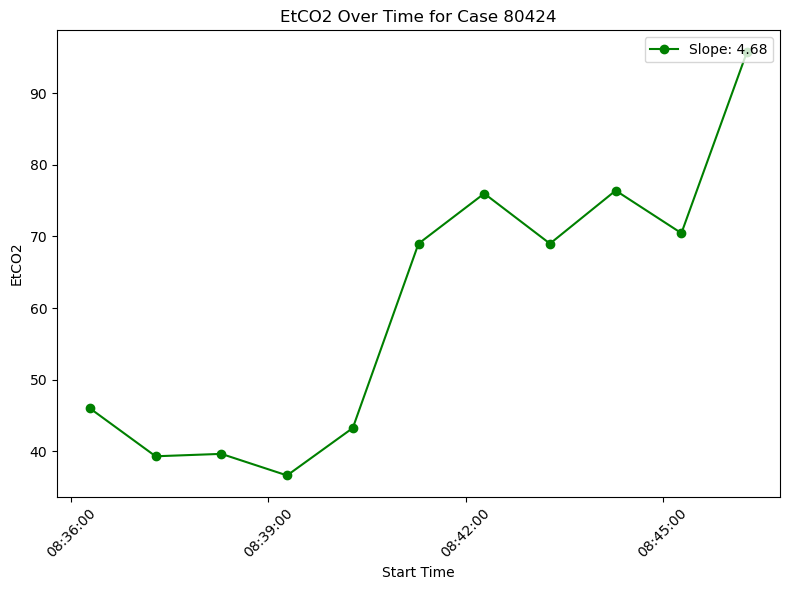

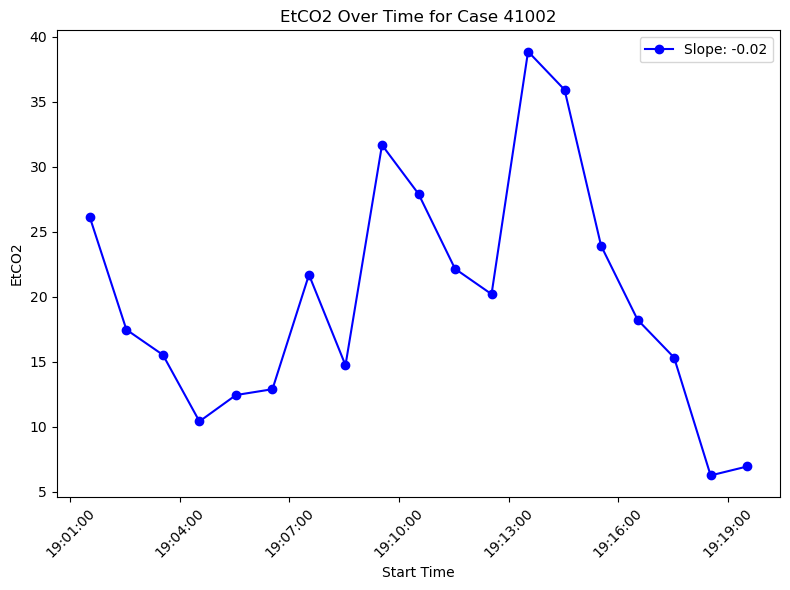

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset
file_path = 'final_data_with_slope.xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Convert 'start' to datetime to use on the x-axis
df['start'] = pd.to_datetime(df['start'], errors='coerce')

# Define the case IDs and their colors
case_ids_to_plot = {80424: 'green', 41002: 'blue'}

# Plot each case individually
for caseid, color in case_ids_to_plot.items():
    # Filter data for the specific caseid
    case_data = df[df['caseid'] == caseid].dropna(subset=['start', 'EtCO2'])
    
    # Check if there is valid data for plotting
    if len(case_data) > 1:
        # Get the precomputed slope value from the first row of this case's data
        slope_value = case_data['EtCO2_slope'].iloc[0]
        
        # Plot EtCO2 vs. start time
        plt.figure(figsize=(8, 6))
        plt.plot(case_data['start'], case_data['EtCO2'], marker='o', color=color, label=f'Slope: {slope_value:.2f}')
        
        # Customize the plot
        plt.title(f'EtCO2 Over Time for Case {caseid}')
        plt.xlabel('Time')
        plt.ylabel('EtCO2')
        plt.legend(loc='upper right')
        
        # Set x-axis ticks to show every 3 minutes
        plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Show the plot
        plt.show()
    else:
        print(f"Not enough data to plot for caseid {caseid}.")


## Using Random Forest for Feature Importance 

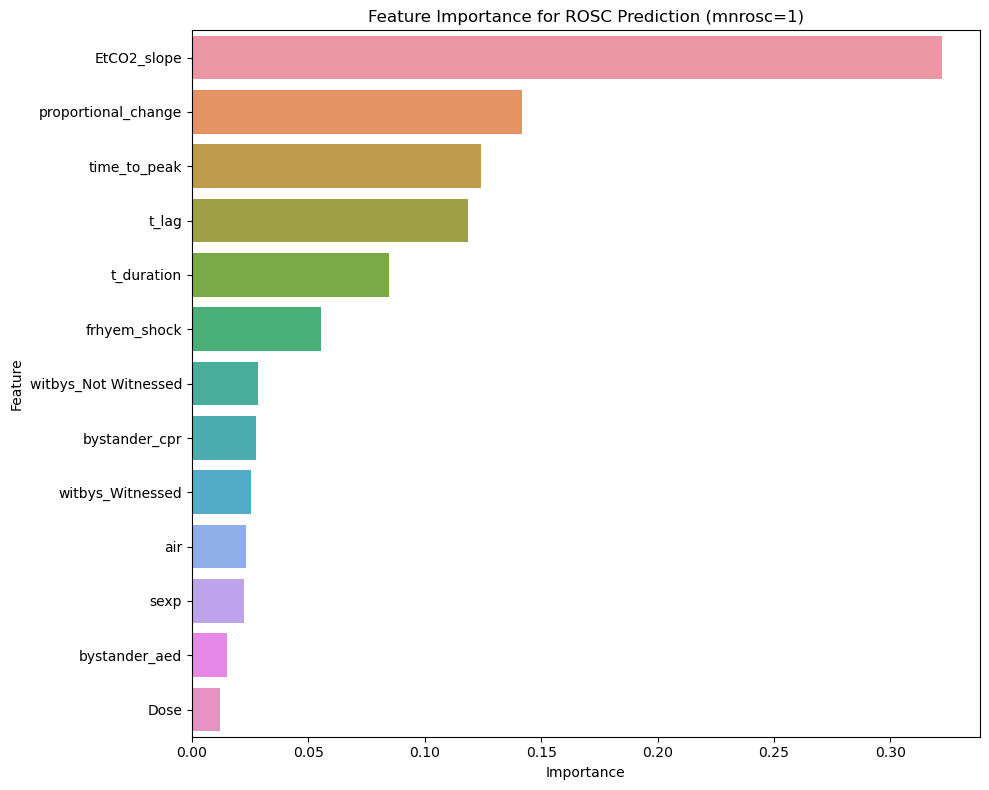

Feature importances for predicting mnrosc = 1:
                 feature  importance
10           EtCO2_slope    0.322313
7    proportional_change    0.141577
8           time_to_peak    0.124264
6                  t_lag    0.118504
9             t_duration    0.084510
1           frhyem_shock    0.055321
11  witbys_Not Witnessed    0.028309
2          bystander_cpr    0.027603
12      witbys_Witnessed    0.025283
4                    air    0.023113
0                   sexp    0.022294
3          bystander_aed    0.014945
5                   Dose    0.011964
Feature importances saved to 'feature_importance_ROSC_prediction.xlsx'


In [47]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
file_path = 'final_data_with_slope.xlsx'  # Adjust this path as needed
df = pd.read_excel(file_path, sheet_name='Wit')

# Encode categorical features: frhyem_shock and air
df['frhyem_shock'] = df['frhyem_shock'].map({'Non-Shockable': 0, 'Shockable': 1})
df['air'] = df['air'].map({'LT': 0, 'ETI': 1}).fillna(-1)  # Mapping blanks to -1 to handle missing values

# One-hot encode 'witbys' without dropping any category
df = pd.get_dummies(df, columns=['witbys'], drop_first=False)

# Drop unnecessary columns
X = df.drop(columns=['mnrosc', 'caseid', 'surv72', 'age_yrs', 'time_to_peak_2', 't_lag_2', 't_duration_2', 'proportional_change_2'])
y = df['mnrosc']  # Target variable for prediction

# Fill any remaining missing values (if any) with 0
X = X.fillna(0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 1.5})  # Adjust class weights to focus on mnrosc = 1 if needed
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Display feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance for ROSC Prediction (mnrosc=1)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print and save feature importances
print("Feature importances for predicting mnrosc = 1:")
print(feature_importances)
feature_importances.to_excel('feature_importance_ROSC_prediction.xlsx', index=False)
print("Feature importances saved to 'feature_importance_ROSC_prediction.xlsx'")

## Odds ratio Calculation

Unique values in 'witbys': ['Not Witnessed' 'Witnessed']
Odds Ratios for each feature:
                 feature  odds_ratio
1           frhyem_shock    2.862178
9            EtCO2_slope    1.815263
11      witbys_Witnessed    1.715413
4                    air    1.273024
8             t_duration    1.109017
5                  t_lag    1.014771
6    proportional_change    0.999228
0                age_yrs    0.992783
7           time_to_peak    0.958953
2          bystander_cpr    0.937271
10  witbys_Not Witnessed    0.577573
3          bystander_aed    0.343647


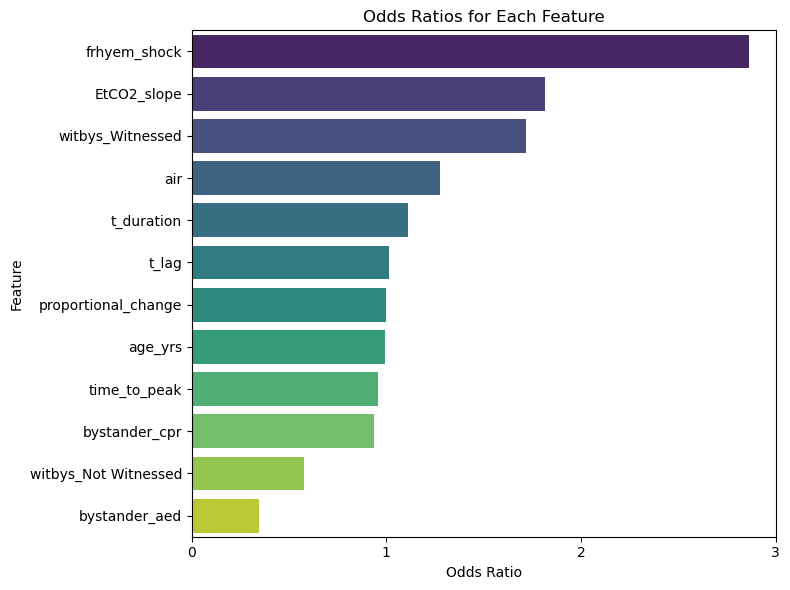

In [60]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
file_path = 'final_data_with_slope.xlsx'  # Adjust this path as needed
df = pd.read_excel(file_path, sheet_name='Wit')

# Check unique values in 'witbys' to understand its categories
print("Unique values in 'witbys':", df['witbys'].unique())

# Encode categorical features: frhyem_shock and air
df['frhyem_shock'] = df['frhyem_shock'].map({'Non-Shockable': 0, 'Shockable': 1})
df['air'] = df['air'].map({'LT': 0, 'ETI': 1}).fillna(-1)  # Mapping blanks to -1 to handle missing values

# Apply one-hot encoding to 'witbys' without manual mapping
df = pd.get_dummies(df, columns=['witbys'], drop_first=False)  # This will add columns like 'witbys_1', 'witbys_2', etc.

# Drop unnecessary duplicates based on all columns (since it's the final data)
df = df.drop_duplicates()

# Define features and target variable
X = df.drop(columns=['mnrosc', 'caseid', 'surv72', 'time_to_peak_2', 't_lag_2', 't_duration_2', 'proportional_change_2', 'Dose', 'sexp'])
y = df['mnrosc']  # Target variable for prediction

# Fill any remaining missing values (if any) with 0
X = X.fillna(0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Calculate odds ratios
odds_ratios = np.exp(log_reg.coef_[0])  # Exponentiate the coefficients to get odds ratios
feature_odds_ratios = pd.DataFrame({'feature': X.columns, 'odds_ratio': odds_ratios})

# Display odds ratios
print("Odds Ratios for each feature:")
print(feature_odds_ratios.sort_values(by='odds_ratio', ascending=False))

# Prepare a DataFrame for plotting
odds_df = feature_odds_ratios.sort_values(by='odds_ratio', ascending=False)
'''
# Plotting odds ratios
plt.figure(figsize=(8, 6))
sns.barplot(x='odds_ratio', y='feature', data=odds_df, palette="viridis")
plt.title('Odds Ratios for Each Feature')
plt.xlabel('Odds Ratio')
plt.ylabel('Feature')
plt.xscale('log')  # Log scale for better visualization of small differences
plt.tight_layout()
plt.show()

# Optionally, save the odds ratios to an Excel file
feature_odds_ratios.to_excel('odds_ratios_ROSC_prediction.xlsx', index=False)
print("Odds ratios saved to 'odds_ratios_ROSC_prediction.xlsx'")

'''

# Plotting odds ratios
plt.figure(figsize=(8, 6))
sns.barplot(x='odds_ratio', y='feature', data=odds_df, palette="viridis")
plt.title('Odds Ratios for Each Feature')
plt.xlabel('Odds Ratio')
plt.ylabel('Feature')

# Set x-axis limits and tick values
plt.xlim(0, 2)
plt.xticks([0, 1, 2, 3], labels=['0', '1', '2', '3'])

plt.tight_layout()
plt.show()


## Cochran-Armitage test

In [57]:
# Load necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import logit

# Load the dataset
file_path = 'final_data_with_slope.xlsx'  # Adjust this path as needed
df = pd.read_excel(file_path, sheet_name='Sheet4')

# Assuming EtCO2_slope is already calculated, categorize it into Low, Medium, High
df['slope_category'] = pd.qcut(df['EtCO2_slope'], q=3, labels=['Low', 'Medium', 'High'])


In [58]:
# Perform logistic regression using slope category as a predictor
df['ROSC'] = df['mnrosc']  # Renaming mnrosc to ROSC for clarity in the model formula

# Logistic regression model with slope category as a predictor for ROSC
model = logit("ROSC ~ C(slope_category, Treatment(reference='Low'))", data=df)
result = model.fit()

# Display the results
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.462370
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   ROSC   No. Observations:                  518
Model:                          Logit   Df Residuals:                      515
Method:                           MLE   Df Model:                            2
Date:                Fri, 15 Nov 2024   Pseudo R-squ.:                  0.1144
Time:                        00:07:22   Log-Likelihood:                -239.51
converged:                       True   LL-Null:                       -270.44
Covariance Type:            nonrobust   LLR p-value:                 3.699e-14
                                                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept         

## Prediction of ROSC

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        76
           1       0.96      0.84      0.90        90

    accuracy                           0.90       166
   macro avg       0.90      0.90      0.90       166
weighted avg       0.91      0.90      0.90       166

Random Forest Confusion Matrix:
[[73  3]
 [14 76]]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85        76
           1       0.91      0.80      0.85        90

    accuracy                           0.85       166
   macro avg       0.85      0.85      0.85       166
weighted avg       0.86      0.85      0.85       166

Logistic Regression Confusion Matrix:
[[69  7]
 [18 72]]


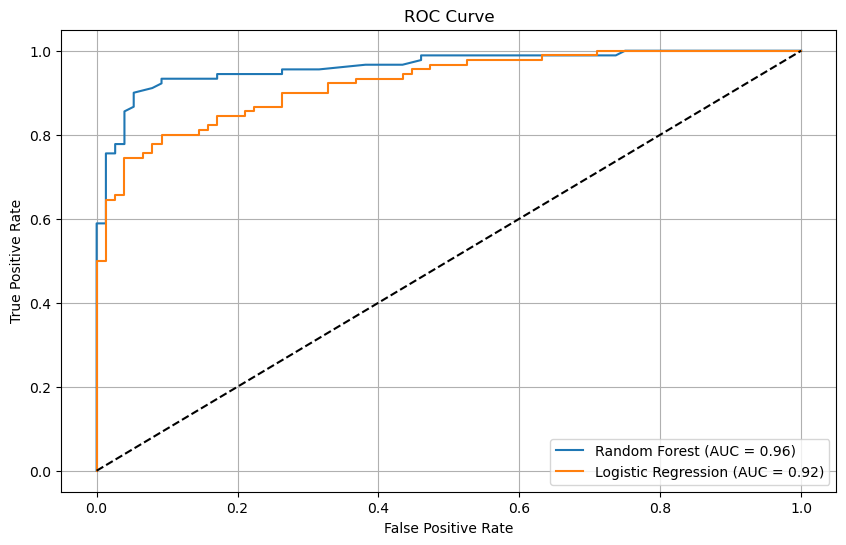

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Load and preprocess the data
file_path = 'final_data_with_slope.xlsx'  # Update this to your path
df = pd.read_excel(file_path, sheet_name='Wit')

# Encode categorical features
df['frhyem_shock'] = df['frhyem_shock'].map({'Non-Shockable': 0, 'Shockable': 1})
df['air'] = df['air'].map({'LT': 0, 'ETI': 1}).fillna(-1)


# Apply one-hot encoding to 'witbys' without manual mapping
df = pd.get_dummies(df, columns=['witbys'], drop_first=False)  # This will add columns like 'witbys_1', 'witbys_2', etc.

# Drop duplicates and unnecessary columns

df = df.drop_duplicates()
X = df.drop(columns=['mnrosc', 'caseid', 'surv72' ,'time_to_peak_2', 't_lag_2', 't_duration_2', 'proportional_change_2'])
y = df['mnrosc']


# Fill any remaining missing values with 0
X = X.fillna(0)

# Handle class imbalance with SMOTE
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Random Forest evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Train Logistic Regression with balanced class weights
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Logistic Regression evaluation
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

# ROC Curve and AUC for both models
plt.figure(figsize=(10, 6))
models = [('Random Forest', rf, y_pred_rf), ('Logistic Regression', lr, y_pred_lr)]
for name, model, y_pred in models:
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


## Saving Random Forest model and testing a random case

In [4]:
import joblib

# Assuming `rf` is your trained Random Forest model
joblib.dump(rf, 'random_forest_model.pkl')
print("Model saved as 'random_forest_model.pkl'")


Model saved as 'random_forest_model.pkl'


In [5]:
import joblib
import pandas as pd


# Load the test data
test_data = pd.DataFrame({
    'caseid': [10267, 10383],
    'surv72': [0, 1],
    'mnrosc': [0, 1],
    'age_yrs': [91, 50],
    'sexp': [0, 1],
    'witbys': [0, 1],
    'frhyem_shock': ['Non-Shockable', 'Shockable'],
    'bystander_cpr': [0, 1],
    'bystander_aed': [0, 0],
    'air': ['LT', 'LT'],
    'Dose': [1, 1],
    't_lag': [3.666666667, 4.283333333],
    'proportional_change': [17.73053703, 75.09680167],
    'time_to_peak': [3.666666667, 4.283333333],
    't_duration': [1, 2],
    't_lag_2': [0, 0],
    't_duration_2': [0, 0],
    'time_to_peak_2': [0, 0],
    'proportional_change_2': [0, 0],
    'EtCO2_slope': [0.313056847, 0.683534461]
})

# Drop non-feature columns like 'caseid', 'surv72', 'mnrosc' (target)
X_test = test_data.drop(columns=['caseid', 'surv72', 'mnrosc'])

# Encode categorical variables
X_test['frhyem_shock'] = X_test['frhyem_shock'].map({'Non-Shockable': 0, 'Shockable': 1})
X_test['air'] = X_test['air'].map({'LT': 0, 'ETI': 1}).fillna(-1)

# Load the pre-trained Random Forest model (replace 'random_forest_model.pkl' with your saved model's filename)
rf_model = joblib.load('random_forest_model.pkl')

# Make predictions
predictions = rf_model.predict(X_test)
probabilities = rf_model.predict_proba(X_test)[:, 1]  # Probability for the positive class (ROSC)

# Display the results
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    print(f"Test Case {i+1} - Prediction: {'ROSC' if pred == 1 else 'Non-ROSC'}, Probability of ROSC: {prob:.2f}")


Test Case 1 - Prediction: Non-ROSC, Probability of ROSC: 0.06
Test Case 2 - Prediction: ROSC, Probability of ROSC: 0.82
